In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(ggplot2))

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”


In [15]:
df <- readRDS('../Data/Full_data.rds') %>% mutate(chunk=as.POSIXct(chunk, tz = "GMT", origin="1970-01-01"))

In [16]:
df$polarity <- as.numeric(df$polarity)
head(df)

,chunk,texts,temp_weighted,cloud_cover_weighted,rainfall_weighted,polarity,standardised_texts,abnormal,daily_policy_index,1_hr_std,⋯,19_hr,20_hr,21_hr,22_hr,23_hr,24_hr,25_hr,26_hr,27_hr,28_hr
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
29,2018-10-26 19:00:00,17,6.034263,21.52583,0,0.04321217,0.4171159,0,131.03,-0.6010679,⋯,6,17,18,22,24,11,9,8,3,3
30,2018-10-26 20:00:00,15,5.561813,16.28374,0,0.04321217,-0.4045199,0,131.03,0.4171159,⋯,7,6,17,18,22,24,11,9,8,3
31,2018-10-26 21:00:00,15,5.399833,17.53819,0,0.04321217,-0.9145045,0,131.03,-0.4045199,⋯,5,7,6,17,18,22,24,11,9,8
32,2018-10-26 22:00:00,19,4.787232,10.76873,0,0.04321217,-0.3375264,0,131.03,-0.9145045,⋯,1,5,7,6,17,18,22,24,11,9
33,2018-10-26 23:00:00,21,4.534415,11.67290,0,0.04321217,1.0419964,0,131.03,-0.3375264,⋯,2,1,5,7,6,17,18,22,24,11
34,2018-10-27 00:00:00,5,4.079211,14.18510,0,0.02031840,-0.8932260,0,112.53,1.0419964,⋯,0,2,1,5,7,6,17,18,22,24


In [10]:
n_rows <- dim(df)[1]

ci <- function(vector) {
  return(1.96*sd(vector)/sqrt(n_rows))
}

chocolate <- df %>% mutate(year = floor_date(chunk, 'year')) %>% 
  as.data.frame %>% group_by(year) %>%
  summarise(texts_mean = mean(texts),
            texts_ci = ci(texts),
            temp_mean = mean(temp_weighted),
            temp_ci = ci(temp_weighted),
            cloud_mean = mean(cloud_cover_weighted),
            cloud_ci = ci(cloud_cover_weighted),
            rain_mean = mean(rainfall_weighted),
            rain_ci = ci(rainfall_weighted),
            polarity_mean = mean(polarity),
            polarity_ci = ci(polarity),
            standardised_texts_mean = mean(standardised_texts),
            standardised_texts_ci = ci(standardised_texts),
            abnormal_mean = mean(abnormal),
            abnormal_ci = ci(abnormal),
            daily_policy_index_mean = mean(daily_policy_index),
            daily_policy_index_ci = ci(daily_policy_index)
            )
chocolate

year,texts_mean,texts_ci,temp_mean,temp_ci,cloud_mean,cloud_ci,rain_mean,rain_ci,polarity_mean,polarity_ci,standardised_texts_mean,standardised_texts_ci,abnormal_mean,abnormal_ci,daily_policy_index_mean,daily_policy_index_ci
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-01,9.60793,0.09438489,7.606990,0.03220408,53.33693,0.2374100,0.1101337,0.002495202,0.03517849,0.0003905017,5.498366e-03,0.01043006,0.01258653,0.001228439,160.2564,0.9016373
2019-01-01,19.01986,0.16509877,10.820335,0.05965447,44.94443,0.2349914,0.1473222,0.003166719,0.03734317,0.0003242016,2.074382e-17,0.01058541,0.01038813,0.001116967,169.2658,0.7870693
2020-01-01,40.51309,0.32442759,11.169976,0.05759923,45.74845,0.2525132,0.1466637,0.003031749,0.05078683,0.0003497345,3.844566e-17,0.01058661,0.01946721,0.001522026,519.4821,3.0723838
2021-01-01,56.53402,0.40457099,10.716130,0.06344455,55.05788,0.2318346,0.1371067,0.003066611,0.04789311,0.0003111060,-1.947169e-17,0.01058541,0.01004566,0.001098591,251.8241,1.5678307
2022-01-01,84.77583,0.70358385,8.950768,0.04621004,51.95411,0.2289654,0.1099237,0.002605842,0.04985248,0.0002984874,2.736257e-04,0.01051403,0.01301461,0.001248656,231.4915,1.2403811


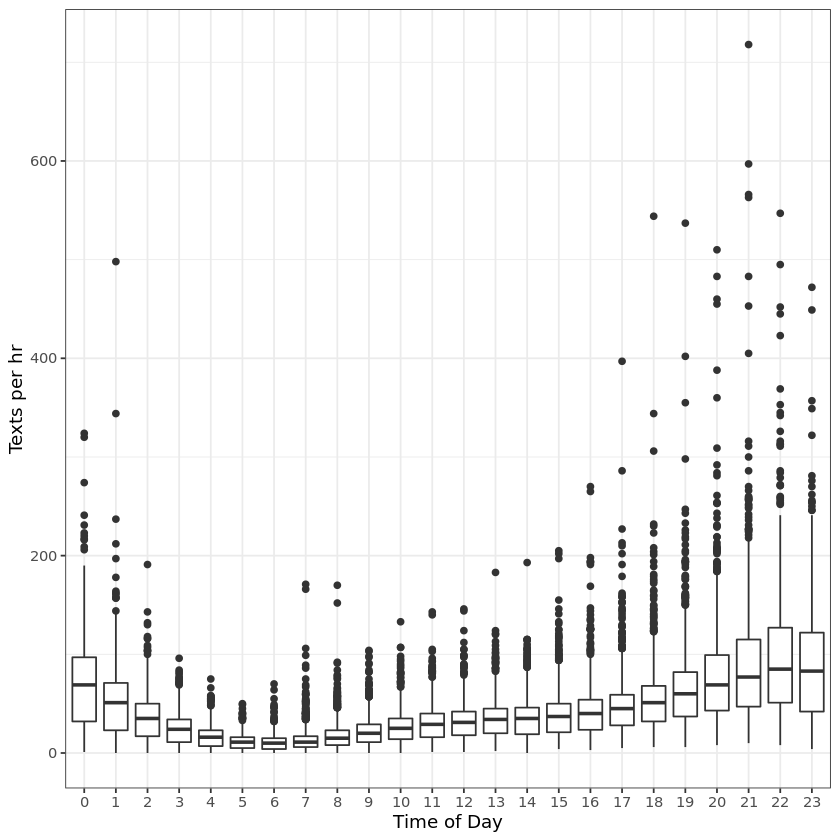

In [20]:
df <- df %>% mutate(hour = hour(chunk))
df$hour_numeric <- as.numeric(substr(df$hour,start=1,stop=2))
df$hour <- substr(df$hour,start=1,stop=2)
df$hour <- as.factor(df$hour_numeric)
ggplot(df,aes(hour,texts)) + geom_boxplot() + #ggtitle("Text Volume (from 03/20)") +
    ylab("Texts per hr") + xlab("Time of Day") + theme_bw()


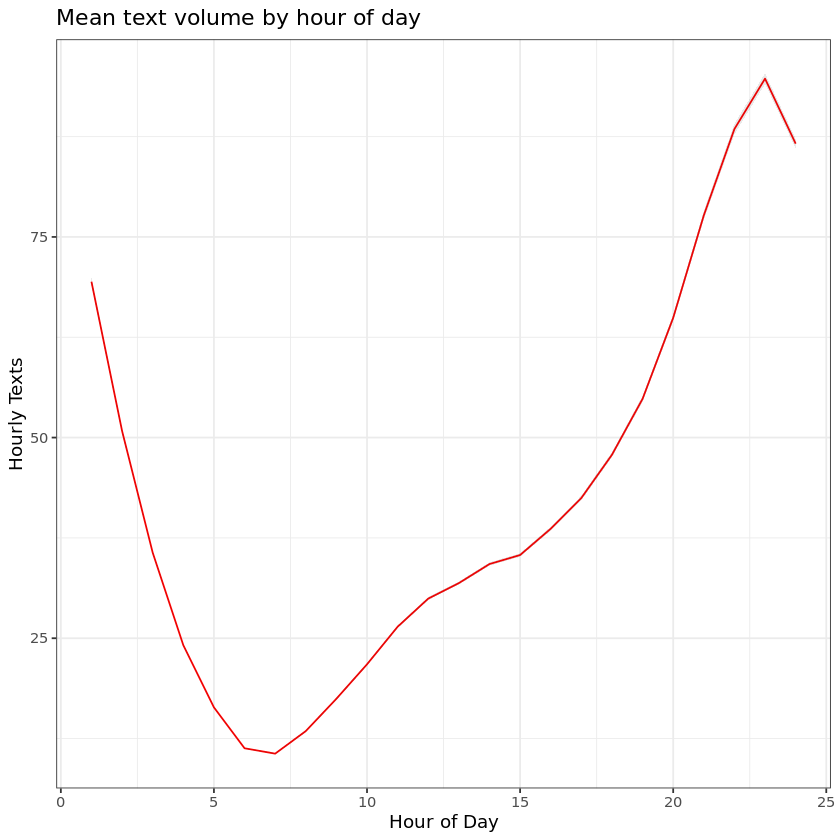

In [23]:
data_length <- dim(df)[1]
byhour <- df %>% as.data.frame %>% group_by(hour) %>% summarise(mean = mean(texts),
                                                    ci = 1.96*sd(texts)/sqrt(data_length)
                                                    )
ggplot(data=byhour,aes(x=as.numeric(hour), y=mean)) + geom_line(col='red') +
  geom_ribbon(aes(ymin = mean-ci, ymax = mean+ci), alpha = 0.1) +
  ylab("Hourly Texts") + xlab("Hour of Day") + ggtitle("Mean text volume by hour of day") + theme_bw()

In [11]:
pdf("../Plots/abnormal_density.pdf") 
df$abnormal_factor <- as.factor(df$abnormal)
cdplot(abnormal_factor ~ chunk, data = df, xlab='Time', ylab = 'Abnormals')
dev.off()

png 
  2

In [17]:
cutoffs_1.5sd <- read.csv("../Data/abnormal_cutoffs_1.5sd.csv")
cutoffs_1.5sd <- cutoffs_1.5sd %>% mutate(chunk=as.POSIXct(chunk, tz = "GMT", origin="1970-01-01")) %>% filter(chunk >= '2018-10-26 19:00:00' & chunk <'2022-06-06 21:00:00')
cutoffs_1.5sd <- cutoffs_1.5sd[order(cutoffs_1.5sd$chunk),]


cutoffs_2sd <- read.csv("../Data/abnormal_cutoffs_2sd.csv")
cutoffs_2sd <- cutoffs_2sd %>% mutate(chunk=as.POSIXct(chunk, tz = "GMT", origin="1970-01-01")) %>% filter(chunk >= '2018-10-26 19:00:00' & chunk <'2022-06-06 21:00:00')
cutoffs_2sd <- cutoffs_2sd[order(cutoffs_2sd$chunk),]

df$abnormals_2sd <- ifelse(df$texts >= cutoffs_2sd$cutoff2, 1, 0)
df$abnormals_1.5sd <- ifelse(df$texts >= cutoffs_1.5sd$cutoff1.5, 1, 0)

In [26]:
df

,chunk,texts,temp_weighted,cloud_cover_weighted,rainfall_weighted,polarity,standardised_texts,abnormal,daily_policy_index,1_hr_std,⋯,22_hr,23_hr,24_hr,25_hr,26_hr,27_hr,28_hr,abnormal_factor,abnormals_2sd,abnormals_1.5sd
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>
29,2018-10-26 19:00:00,17,6.034263,21.525829,0.000000000,0.04321217,0.41711591,0,131.03,-0.60106793,⋯,22,24,11,9,8,3,3,0,0,0
30,2018-10-26 20:00:00,15,5.561813,16.283735,0.000000000,0.04321217,-0.40451992,0,131.03,0.41711591,⋯,18,22,24,11,9,8,3,0,0,0
31,2018-10-26 21:00:00,15,5.399833,17.538188,0.000000000,0.04321217,-0.91450446,0,131.03,-0.40451992,⋯,17,18,22,24,11,9,8,0,0,0
32,2018-10-26 22:00:00,19,4.787232,10.768733,0.000000000,0.04321217,-0.33752637,0,131.03,-0.91450446,⋯,6,17,18,22,24,11,9,0,0,0
33,2018-10-26 23:00:00,21,4.534415,11.672903,0.000000000,0.04321217,1.04199641,0,131.03,-0.33752637,⋯,7,6,17,18,22,24,11,0,0,0
34,2018-10-27 00:00:00,5,4.079211,14.185104,0.000000000,0.02031840,-0.89322604,0,112.53,1.04199641,⋯,5,7,6,17,18,22,24,0,0,0
35,2018-10-27 01:00:00,8,4.028406,24.473330,0.000000000,0.02031840,0.63323779,0,112.53,-0.89322604,⋯,1,5,7,6,17,18,22,0,0,0
36,2018-10-27 02:00:00,3,3.646402,21.989287,0.000000000,0.02031840,-0.35856858,0,112.53,0.63323779,⋯,2,1,5,7,6,17,18,0,0,0
37,2018-10-27 03:00:00,0,3.128456,14.128127,0.000000000,0.02031840,-1.64805080,0,112.53,-0.35856858,⋯,0,2,1,5,7,6,17,0,0,0


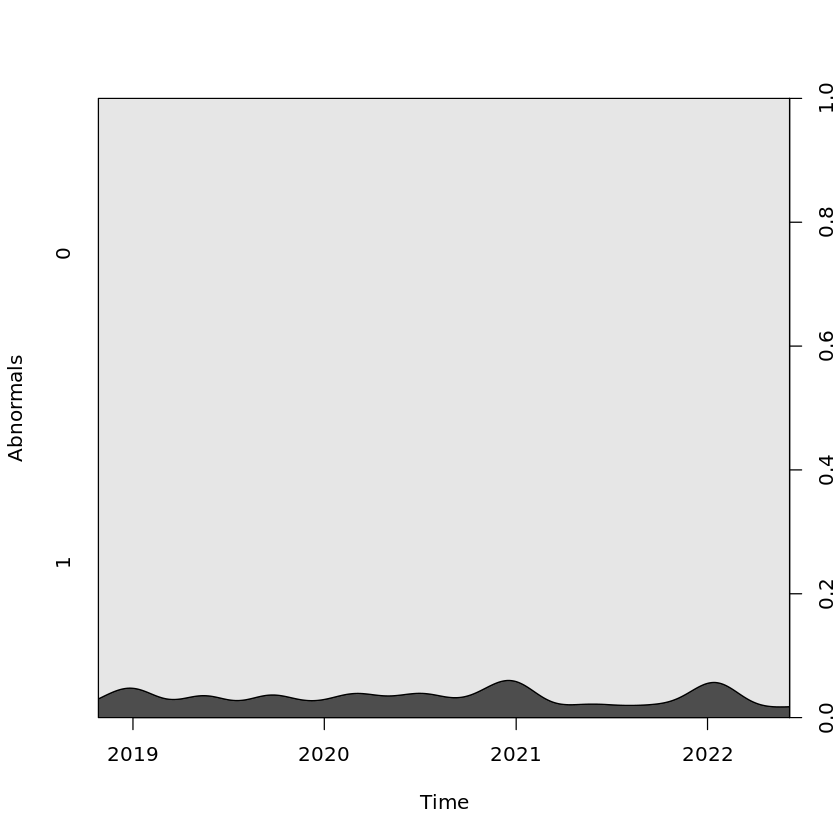

In [27]:
df$abnormals_2sd <- as.factor(df$abnormals_2sd)
cdplot(abnormals_2sd ~ chunk, data = df, xlab='Time', ylab = 'Abnormals')

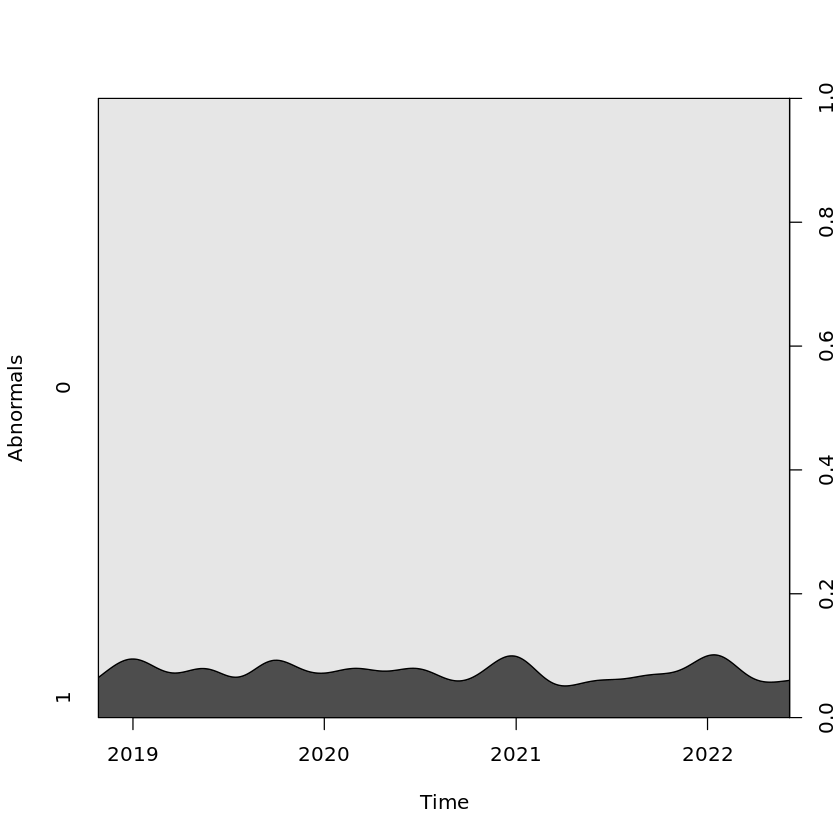

In [28]:
df$abnormals_1.5sd <- as.factor(df$abnormals_1.5sd)
cdplot(abnormals_1.5sd ~ chunk, data = df, xlab='Time', ylab = 'Abnormals')

In [32]:
sum(as.numeric(df$abnormals_1.5sd)) - 31658 

[1] 2370

In [18]:
cutoffs <- read.csv("../Data/abnormal_cutoffs.csv") %>% mutate(chunk=as.POSIXct(chunk, tz = "GMT", origin="1970-01-01"))
df <- df %>% left_join(cutoffs, by = c('chunk'))

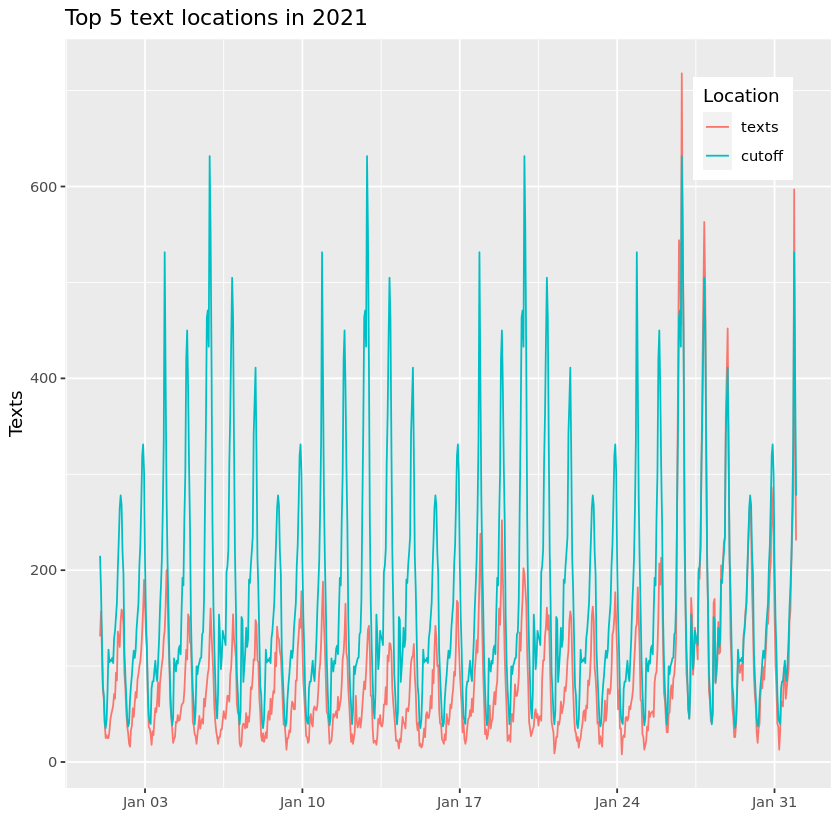

In [19]:
df_plot <- df %>% filter(chunk >= '2022-01-01 00:00:00' & chunk < '2022-02-01 00:00:00') %>% select(chunk, texts, cutoff)
library("reshape2")
df_plot <- melt(df_plot, id='chunk')

ggplot(data=df_plot,
       aes(x=chunk, y=value, colour=variable)) +
       theme(
       legend.position = c(.95, .95),
       legend.justification = c("right", "top"),
       legend.box.just = "right",
       legend.margin = margin(6, 6, 6, 6)
       ) + labs(colour = "Location") + xlab("") + ylab("Texts") + ggtitle("Top 5 text locations in 2021") +
       geom_line()

In [20]:
cutoffs <- read.csv("../Data/Q1_22_cutoffs.csv") 
df <- df %>% mutate(hour = hour(chunk), weekday = weekdays(chunk))
df <- df %>% left_join(cutoffs, by = c('hour', 'weekday'))


In [21]:
df <- df %>% rename(Q1_22_cutoffs = cutoff.x, Q2_22_cutoffs = cutoff.y)

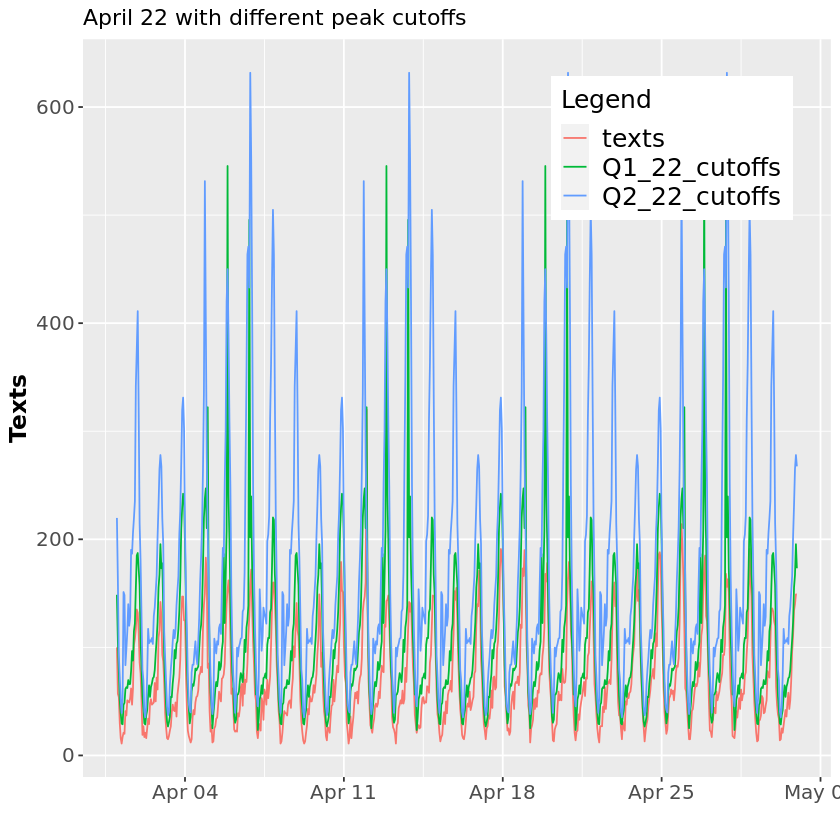

In [30]:
df_plot <- df %>% filter(chunk >= '2022-04-01 00:00:00' & chunk < '2022-05-01 00:00:00') %>% select(chunk, texts, Q1_22_cutoffs, Q2_22_cutoffs)
library("reshape2")
df_plot <- melt(df_plot, id='chunk')

ggplot(data=df_plot,
       aes(x=chunk, y=value, colour=variable)) +
       theme(
       legend.position = c(.95, .95),
       legend.justification = c("right", "top"),
       legend.box.just = "right",
       legend.margin = margin(6, 6, 6, 6),
       legend.text = element_text(size=15),
        legend.title = element_text(size=15),
           axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")
       ) + labs(colour = "Legend") + xlab("") + ylab("Texts") + ggtitle("April 22 with different peak cutoffs") +
       geom_line()

ggsave("../Plots/April22_cutoffs.pdf", height = 10, width = 20) 

In [9]:
pdf("../Plots/ACF.pdf") 
plot <- acf(df$texts,plot=FALSE)
plot(plot, main="Text Volume ACF")
dev.off()

png 
  2

In [10]:
pdf("../Plots/PACF.pdf") 
plot <- pacf(df$texts,plot=FALSE)
plot(plot, main="Text Volume PACF")
dev.off()

png 
  2